# Epidemic mitigation project

For question 3 we reuse the tutorial environment

### Importing the relevant packages
If the environment is correctly setup you should be able to sucessfully import the following packages.

In [1]:
from gym import spaces
import matplotlib.pyplot as plt

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn
import seaborn as sns

SEED = 69
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

%matplotlib inline

In [2]:
# Some code to make the picture a bit nicer for the report
SAVE_REPORT = False
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
# does need cm-super, dvipng and latex to be installed
if SAVE_REPORT:
        plt.rcParams.update(tex_fonts)

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.
    from: https://jwalton.info/Embed-Publication-Matplotlib-Latex/

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27
    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2
    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)
    return fig_dim


In [3]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map

## Implementing the DQN agent, with binary action space

In [25]:
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4
SCALE = 100

def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
        
    return action

def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    obvSpace = torch.Tensor(np.stack((infected, dead))).unsqueeze(0)
    return obvSpace

In [27]:
action_space        =   spaces.Discrete(2)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
print(f"Number cities: {dyn.n_cities} and env_step_length: {dyn.env_step_length}")
print(f"sampled action : {action_space.sample()}")
print(f"Sampled observation (shape {observation_space.sample().shape}) first dimension is infected & dead")
#plt.matshow(observation_space.sample()[0,:,:])
#plt.show()

Number cities: 9 and env_step_length: 7
sampled action : 1
Sampled observation (shape (2, 9, 7)) first dimension is infected & dead


In [26]:
env = Env(dyn,
            action_space=action_space,
            observation_space=observation_space,
            observation_preprocessor=observation_preprocessor,
            action_preprocessor=action_preprocessor)

In the following cell we show how to subclass the agent class. (Here to create a fully random dummy agent with 5 actions).

In [17]:
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
random.seed(SEED)

In [19]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [20]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.input = nn.Linear(n_observations, 64)
        self.layer1 = nn.Linear(64, 32)
        self.layer2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        # TODO maybe 1/4 scale?
        x = x**0.25
        x = F.relu(self.input(x))
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.output(x)

In [57]:
LR = 5*10**-3
DF = 0.9
MS = 20_000
#BS = 2048
BS = 64

update_every = 5 # episodes
episodes = 500

In [58]:
class DQNagent(Agent):
    def __init__(self,  env:Env):
        self.env = env
        # env.observation_space.shape[0]
        self.dqn = DQN(2*9*7, env.action_space.n)
        self.memory = ReplayMemory(MS)
        self.optimizer = optim.AdamW(self.dqn.parameters(), lr=LR, amsgrad=True)
        self.epsilon = 0.7

    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self,):
        if len(self.memory) < BS:
            return
        transitions = self.memory.sample(BS)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.dqn(state_batch).gather(1, action_batch).argmax(1)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(BS)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.dqn(non_final_next_states).max(1)[0]
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * DF) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        #torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
        self.optimizer.step()
    
    def reset(self,):
        # This should be called when the environment is reset
        self.dqn = DQN(2*9*7, env.action_space.n)
        self.memory = ReplayMemory(MS)
        self.optimizer = optim.AdamW(self.dqn.parameters(), lr=LR, amsgrad=True)
    
    def act(self, obs):
        # eps greedy choosing
        if random.random() < self.epsilon:
            with torch.no_grad():
                # The unmitigated agent always takes the same action, i.e. do nothing
                containment = self.dqn(obs.flatten())
                return torch.argmax(containment).item()
        else:
            return torch.tensor(self.env.action_space.sample(), dtype=torch.long)

#### Running with this agent

In [59]:
agent = DQNagent(env)

def run_simulation(agent,env,seed):
    """ Run the simulation """
    log = []
    #agent.reset()
    def run_episode():
        finished = False
        obs, info = env.reset(seed)
        #deaths = []
        rewards = []
        while not finished:
            # Each action is done per week
            action = agent.act(obs)
            old_obs = obs
            # Meaning also the log info is per week
            obs, R, finished, info = env.step(action)
            # Log this step
            #deaths.append(info.total.dead)
            rewards.append(R)
            #log.append(info) # save the information dict for logging
            if not finished:
                # Add the transition to the replay memory
                agent.memory.push(old_obs, action, obs, R)
            # Optimize the model
            agent.optimize_model()
        
        """ Parse the logs """
        #deaths = np.array(deaths)
        return np.sum([r.numpy()[0] for r in rewards])
        #total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
        #cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
        #actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

    for i in range(episodes):
        reward = run_episode()
        print(f"Episode {i} reward: {reward}")
        if i % update_every == 0:
            # TODO run eval 20 episodes average with epsilon of 0
            pass

run_simulation(agent,env,SEED)

Episode 0 reward: -189.45716857910156
Episode 1 reward: -229.8255615234375


TypeError: expected Tensor as element 1 in argument 0, but got int

1. A plot of variables s e i r d per week total over time, where time is measured in weeks and all the variables share the y axis scaling.

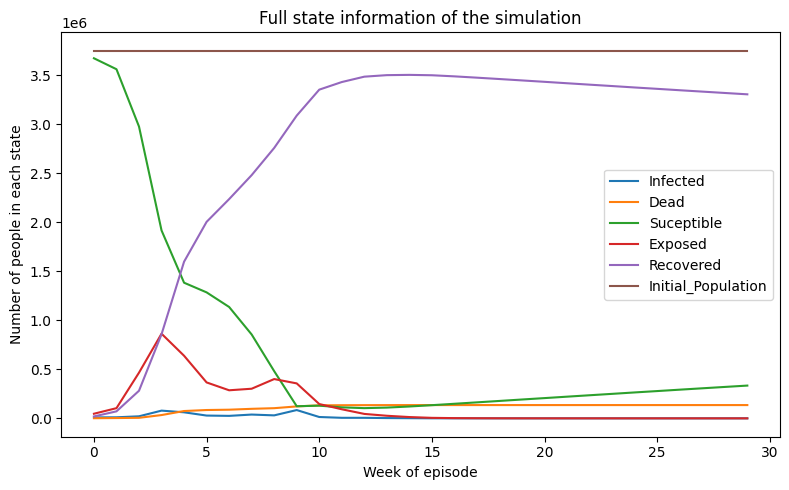

In [46]:
size = set_size(400) if SAVE_REPORT else (8, 5)
fig = plt.figure(figsize=size)
[plt.plot(y) for y in total.values()]
plt.legend([k.title() for k in total.keys()])
plt.title('Full state information of the simulation')
plt.ylabel('Number of people in each state')
plt.xlabel('Week of episode')
plt.tight_layout()
if SAVE_REPORT:
    plt.savefig('figures/created/Q1-fullState.png', dpi=300)
else:
    plt.show()

2. A plot of variables i d total over time, where time is measured in weeks and all the variables share the y axis scaling.

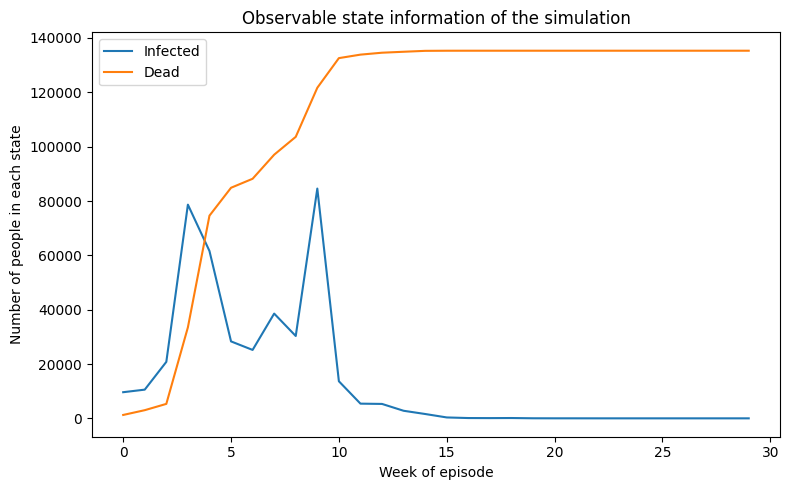

In [47]:
size = set_size(400) if SAVE_REPORT else (8, 5)
fig = plt.figure(figsize=size)
[plt.plot(total[y]) for y in ['infected','dead']]
plt.legend(['Infected','Dead'])
plt.title('Observable state information of the simulation')
plt.ylabel('Number of people in each state')
plt.xlabel('Week of episode')
plt.tight_layout()
if SAVE_REPORT:
    plt.savefig('figures/created/Q1-observableState.png', dpi=300)
else:
    plt.show()

3. A set of plots of variables i d city over time, where time is measured in weeks (one subplot per-city, variables share the y-scaling per-city).

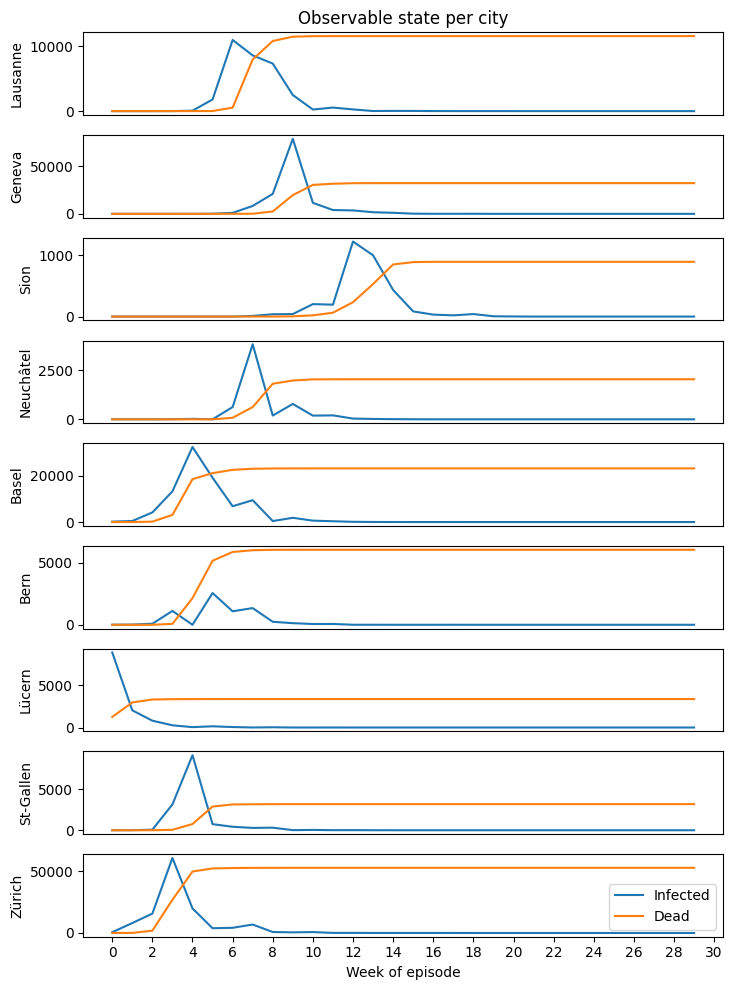

In [48]:
# No modification necessary from the tutorial code
from matplotlib.ticker import MultipleLocator

size = set_size(400) if SAVE_REPORT else (14, 10)
fig = plt.figure(figsize=size)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Zürich'].set_xlabel('Week of episode')
ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))
ax_right['Lausanne'].set_title('Observable state per city')
plt.legend(['Infected','Dead'])
fig.tight_layout()
if SAVE_REPORT:
    plt.savefig('figures/created/Q1-observableStatePerCity.png', dpi=300)
else:
    plt.show()

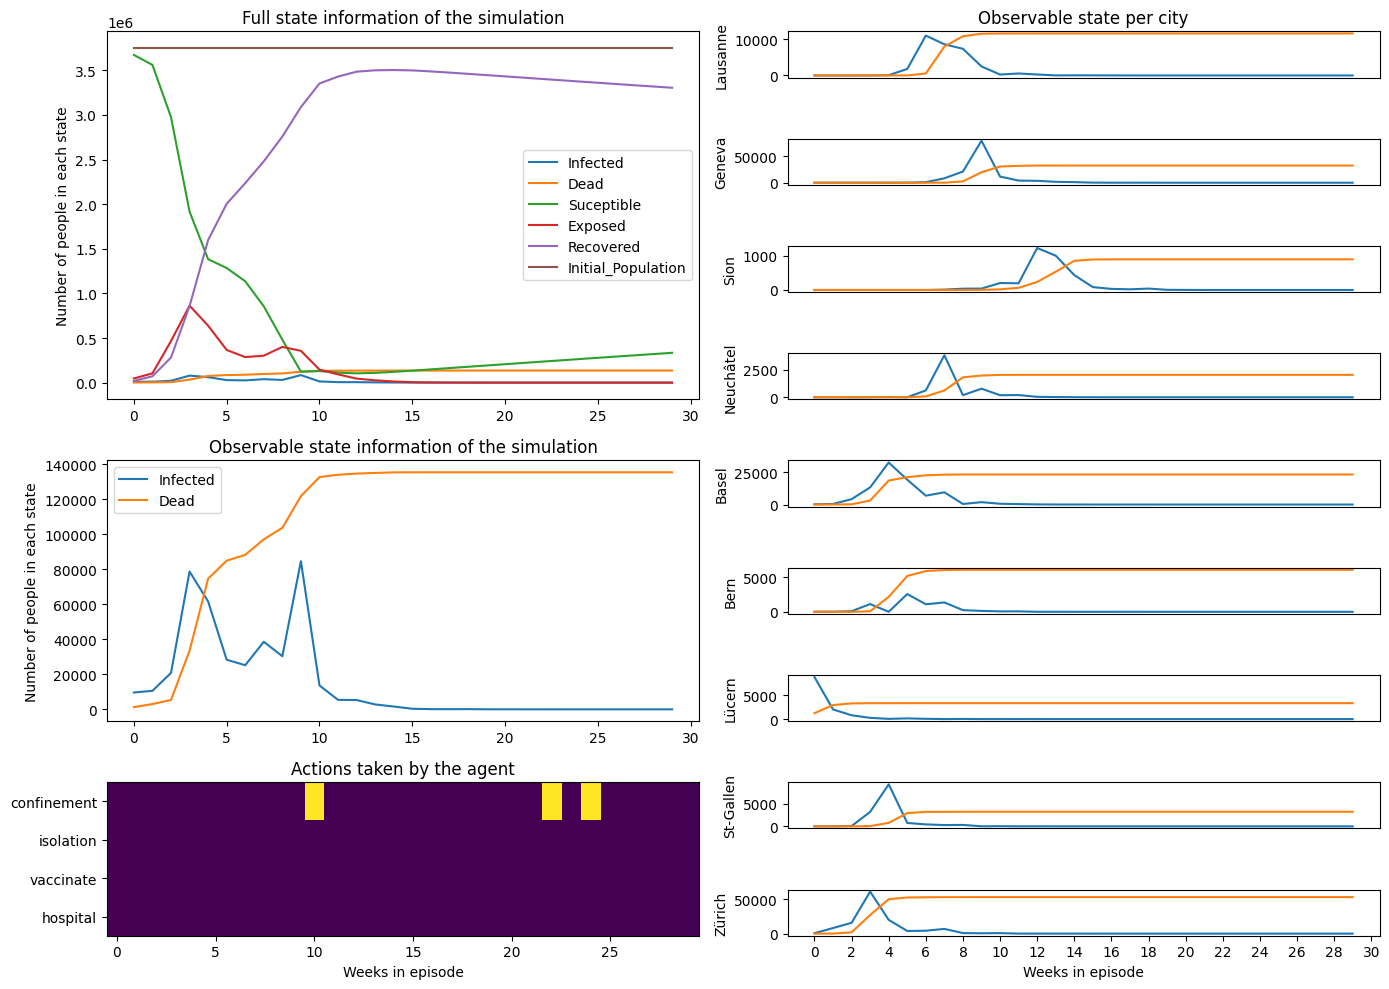

In [49]:
# Try single plot
size = set_size(700) if SAVE_REPORT else (14, 10)
fig = plt.figure(figsize=size)
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend([t.title() for t in total.keys()])
ax_leftstate.set_title('Full state information of the simulation')
ax_leftstate.set_ylabel('Number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['Infected','Dead'])
ax_leftobs.set_title('Observable state information of the simulation')
ax_leftobs.set_ylabel('Number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions taken by the agent')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('Weeks in episode')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Zürich'].set_xlabel('Weeks in episode')
ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))
ax_right['Lausanne'].set_title('Observable state per city')

fig.tight_layout()
fig.tight_layout()
if SAVE_REPORT:
    plt.savefig('figures/created/Q1-complete.png', dpi=300)
else:
    plt.show()

### Multiple simulations
Running a suimulation of 50 enviroments  

In [ ]:
def simulation(agent,env,n):
    info = []
    for i in range(n):
        # Run the agent with seed n, returns deaths, rewards, total, cities, actions
        info.append(run_simulation(agent,env,i))
    return info
info = simulation(agent,env,50)

In [ ]:
# process simulations
conf_days = [np.sum(c[4]["confinement"])*7 for c in info]
rewards = [np.mean(c[1]) for c in info]
deaths = [d[0][-1] for d in info] 

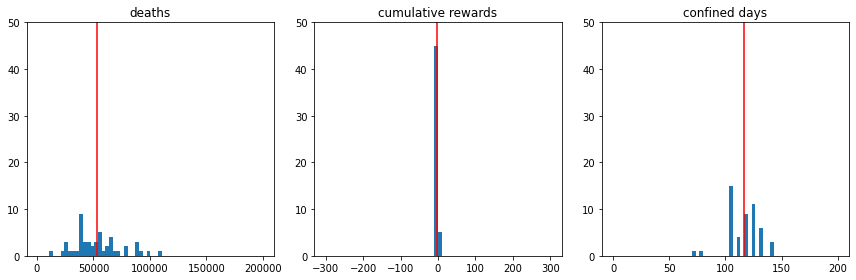

Average death number: 53403.72
Average cumulative reward: -2.28227162361145
Average number of confined days: 116.9


In [ ]:
""" As it is deterministic we really don't need to get anything else than deaths and rewards """
""" Plot example """
fig, ax = plt.subplots(1,3,figsize=(12,4))
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
hist_avg(ax[0], deaths,'deaths')
hist_avg(ax[1], rewards,'cumulative rewards')
hist_avg(ax[2], conf_days,'confined days')
fig.tight_layout()
plt.show()

""" Print example """
print(f'Average death number: {np.mean(deaths)}')
print(f'Average cumulative reward: {np.mean(rewards)}')
print(f'Average number of confined days: {np.mean(conf_days)}')
